#**Прогнозирование уровня риска во время беременности**

**Описание проекта:** Имеется набор данных с возрастом, артериальным давлением, уровнем глюкозы в крови, температурой тела, а также частотой сердцебиения беременных женщин. Необходимо по этим данным спрогнозировать уровень риска во время беременности.
  
**Цель исследования** — создать и обучить прогностическую модель рисков во время беременности.

**Описание данных:**  
`Age` — возраст в годах, при котором наступила беременность  
`SystolicBP` — верхнее значение артериального давления в мм рт. ст.  
`DiastolicBP` — нижнее значение артериального давления в мм рт. ст.  
`BS` — уровень глюкозы в крови выраженный в молярной концентрации ммоль/л.  
`BodyTemp` - температура тела в градусах Фаренгейта  
`HeartRate` — частота сердцебиения в состоянии покоя в ударах в минуту.  
`RiskLevel` — уровень риска во время беременности  

Импортируем полезные библиотеки, объявим константы, зададим параметры по умолчанию и напишем функции, которые понадобятся нам в дальнейшем

In [1]:
!pip install phik optuna scikit-learn~=1.5.0

# data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# math and optimization
import optuna
import phik
from phik.report import plot_correlation_matrix

# utility
import os
from IPython.core.display import display, HTML
from functools import partial

# sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# lightgbm
from lightgbm import LGBMClassifier

# constant values
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Прогнозирование уровня риска во время беременности'
RANDOM_STATE = 884002
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

# set default values
display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
set_config(display='diagram')

# function returns first n powers of 2
def powers_of_two(n):
    return [2**i for i in range(1, n + 1)]

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Загрузка и разведочный анализ данных:**


In [2]:
data = pd.read_csv(os.path.join(DATA_PATH, 'Maternal Health Risk Data Set.csv'))

## **Ознакомимся с набором данных:**

In [3]:
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0000,98.0000,86,high risk
1,35,140,90,13.0000,98.0000,70,high risk
2,29,90,70,8.0000,100.0000,80,high risk
3,30,140,85,7.0000,98.0000,70,high risk
4,35,120,60,6.1000,98.0000,76,low risk


## **Отобразим информацию для краткого обзора данных:**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


## **Проверим наличие дубликатов:**

In [5]:
data.duplicated().any()

True

## **Отобразим таблицу с описательной статистикой столбцов:**

In [6]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.0000,1014.0000,1014.0000,1014.0000,1014.0000,1014.0000
mean,29.8718,113.1982,76.4606,8.7260,98.6651,74.3018
std,13.4744,18.4039,13.8858,3.2935,1.3714,8.0887
min,10.0000,70.0000,49.0000,6.0000,98.0000,7.0000
25%,19.0000,100.0000,65.0000,6.9000,98.0000,70.0000
50%,26.0000,120.0000,80.0000,7.5000,98.0000,76.0000
75%,39.0000,120.0000,90.0000,8.0000,98.0000,80.0000
max,70.0000,160.0000,100.0000,19.0000,103.0000,90.0000


## **Отобразим гистограммы распределений для столбцов:**

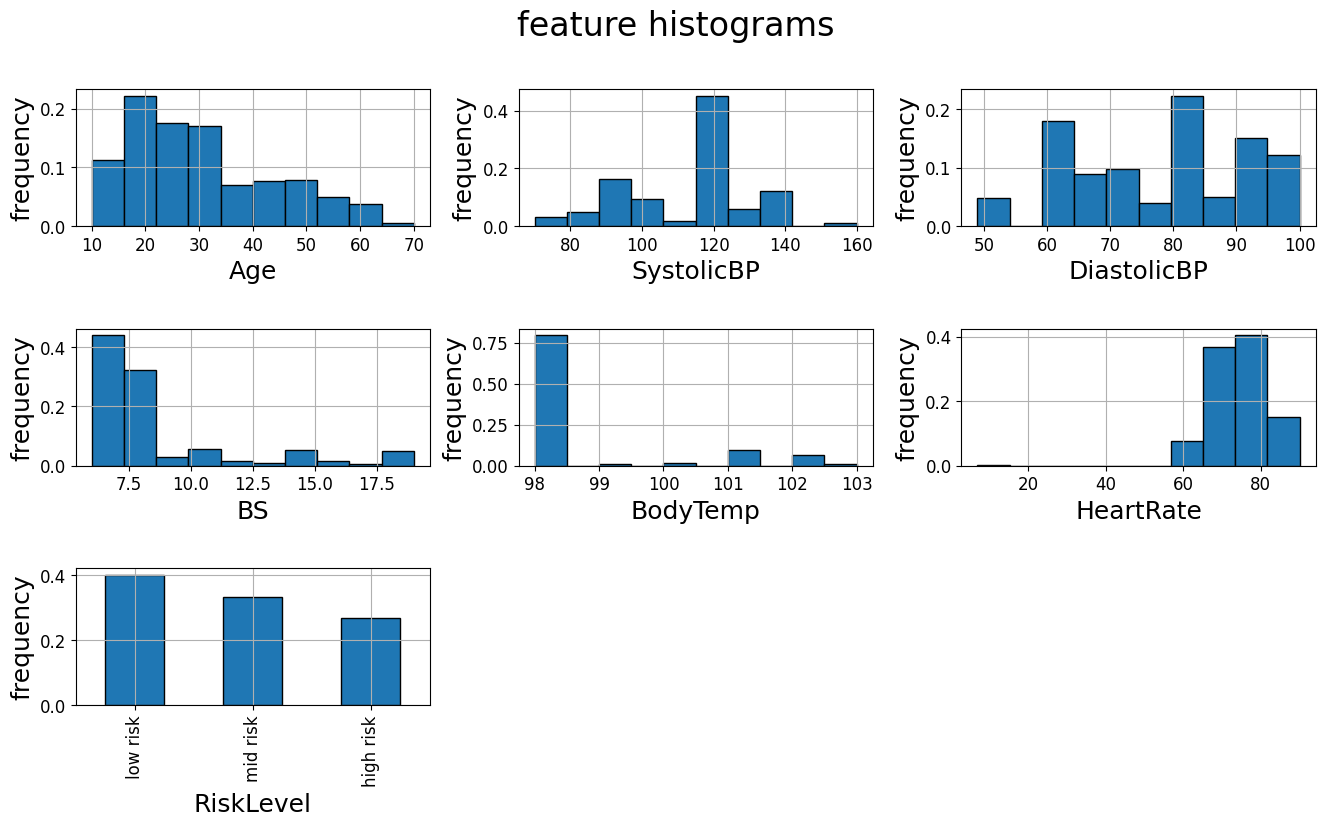

In [7]:
fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.25, hspace=0.75)
fig.suptitle('feature histograms', fontsize=24);

for i, col in enumerate(data.columns):
    ax = fig.add_subplot(3, 3, i + 1)

    # Отобразим количественные и категориальные столбцы соответствующими методами
    if np.issubdtype(data[col].dtype, np.number):
        data[col].plot(kind='hist', edgecolor='black', weights=np.ones_like(data[col])/float(len(data[col])))
    else:
        data[col].value_counts(normalize=True).plot(kind='bar', edgecolor='black')

    ax.set_xlabel(col)
    ax.set_ylabel('frequency')
    ax.grid(visible=True)

## **Отобразим таблицу с попарными корреляциями столбцов:**


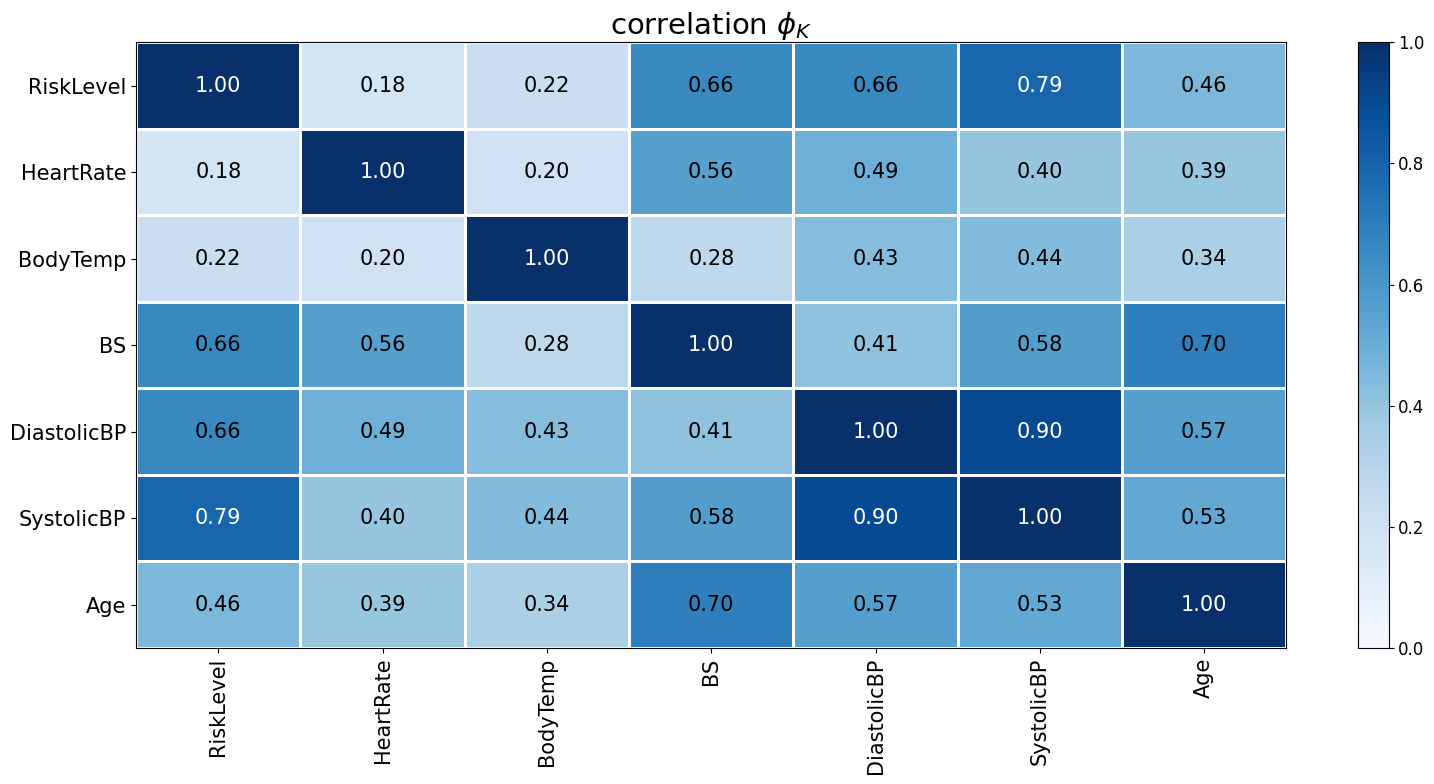

In [8]:
phik_overview = data.phik_matrix(interval_cols=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'])
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                            vmin=0, vmax=1, color_map='Blues',
                            title=r'correlation $\phi_K$', fontsize_factor=1.5, figsize=(16, 8))
plt.tight_layout()

## **Краткий вывод:**
- в данных отсутствуют неинформативные столбцы
- в данных присутствуют нарушения правила хорошего стиля в названиях столбцов
- в данных отсутствуют несоответствия типов в столбцах
- в данных отсутствуют пропуски в столбцах
- в данных присутствуют дубликаты
- в данных присутствуют аномальные значения
- в данных присутствуют намёки на дисбаланс классов в целевом признаке
- в данных присутствуют намёки на мультиколлинеарность


# **Предобработка данных**

## **Исправим нарушения правил хорошего стиля в названиях признаков:**
- несколько слов в названии запишем в «змеином_регистре»
- все символы сделаем строчными
- устраним пробелы

In [9]:
data.rename(columns={
    'Age': 'age',
    'SystolicBP': 'systolic_pressure',
    'DiastolicBP': 'diastolic_pressure',
    'BS': 'blood_sugar',
    'BodyTemp': 'body_temperature',
    'HeartRate': 'heart_rate',
    'RiskLevel': 'risk_level'
    }, inplace=True)

## **Исправим несоответствия типов у признаков:**
В данных отсутствуют несоответствия типов в столбцах

## **Добавим новые признаки:**
Первое что приходит на ум - категоризация количественных признаков. Например, можно создать категории:
- возраста (`young`, `middle_age` и `old`)
- температуры тела (`healthy`, `unhealthy`)
- наличия сахарного диабета при беременности (`no diabetes`, `likely`. `most certainly`)  

Учитывая, что в данных присутствует слишком малое количество объектов (чуть более $1000$), добавим только последний вариант, чтобы не увеличивать размерность данных слишком сильно

Данные о нормальных и аномальных концентрациях сахара в крови для беременных взяты из [статьи](https://www.mayoclinic.org/diseases-conditions/gestational-diabetes/diagnosis-treatment/drc-20355345)

In [10]:
def gestational_diabetes(blood_sugar):
    if blood_sugar < 7.8:
        return 'no diabetes'
    elif 7.8 <= blood_sugar < 10.6:
        return 'likely'
    else:
        return 'gestational diabetes'

data['gestational_diabetes'] = data.blood_sugar.apply(gestational_diabetes)

## **Удалим неинформативные признаки, которые не несут ценности для прогноза:**
В данных отсутствуют неинформативные столбцы


## **Обработаем пропущенные значения:**
В данных отсутствуют пропущенные значения


## **Обработаем дубликаты:**

Проверим наличие неявных дубликатов

In [11]:
# check
data.risk_level.unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

Проверим наличие явных дубликатов

In [12]:
# check
pd.DataFrame([[data.duplicated().sum(), round(data.duplicated().sum() / len(data), 4)]],
             index=['duplicates'],
             columns=['n_duplicates', '%_duplicates'])

,n_duplicates,%_duplicates
duplicates,562,0.5542


В данных отсутствуют неявные дубликаты. Проанализируем как удаление явных дубликатов из данных может повлиять на распределение признаков

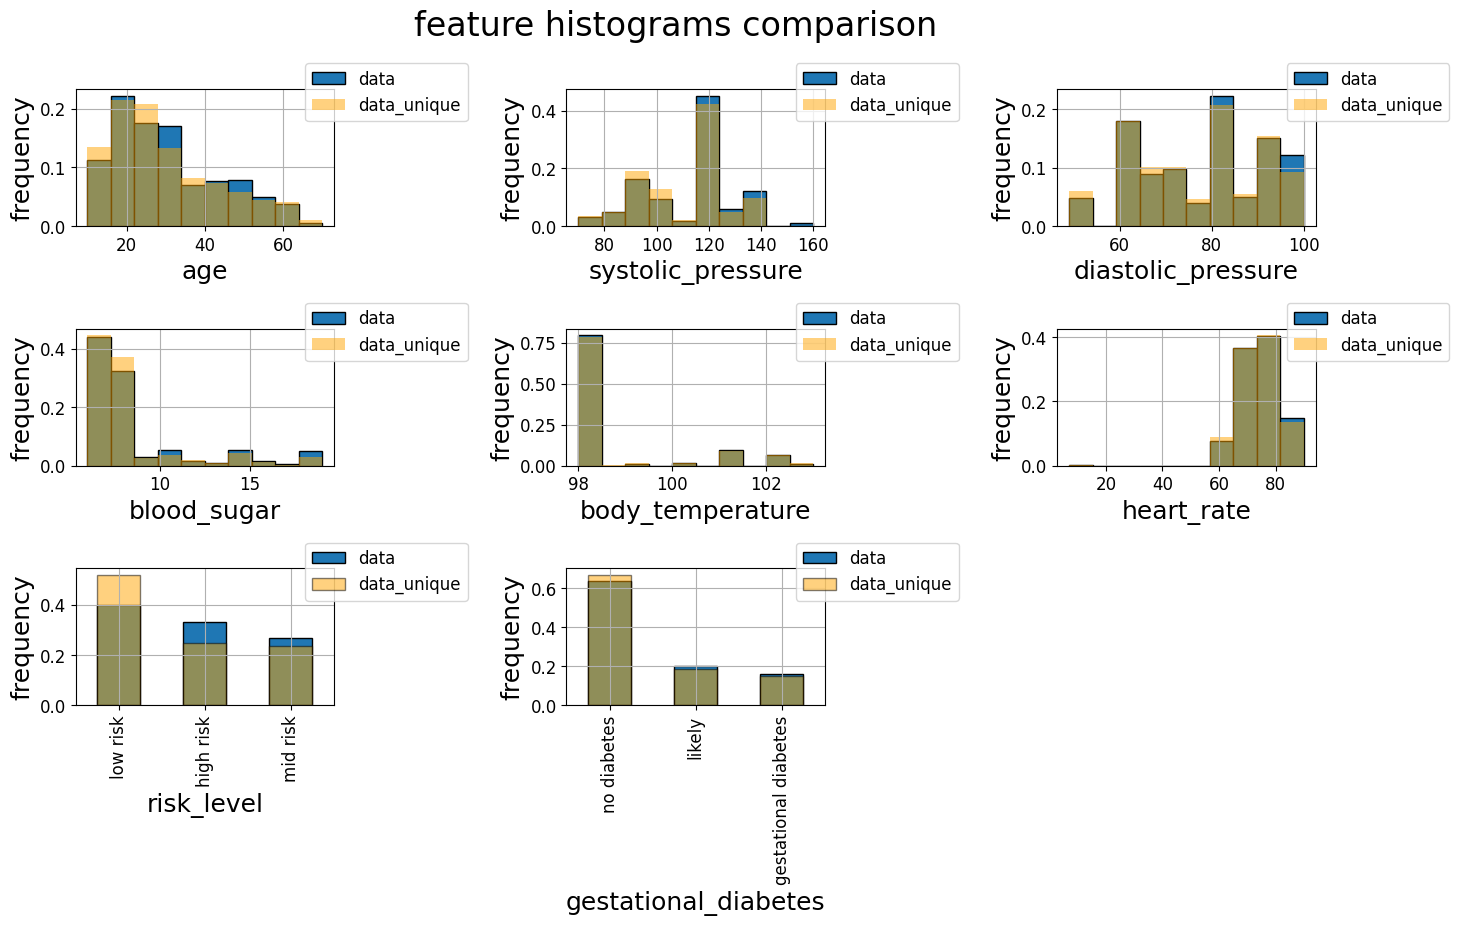

In [13]:
data_unique = data[~data.duplicated()]

fig = plt.figure(figsize=(16, 8))
fig.suptitle('feature histograms comparison', fontsize=24);
plt.subplots_adjust(wspace=0.9, hspace=0.75)

for i, col in enumerate(data.columns):
    ax = fig.add_subplot(3, 3, i + 1)

    # Отобразим количественные и категориальные столбцы соответствующими методами
    if np.issubdtype(data[col].dtype, np.number):
        data[col].plot(kind='hist', edgecolor='black', weights=np.ones_like(data[col])/float(len(data[col])))
        data_unique[col].plot(kind='hist',
                                weights=np.ones_like(data_unique[col])/float(len(data_unique[col])),
                                color='orange',
                                alpha=0.5,
                                ax=ax)
    else:
        data[col].value_counts(normalize=True).plot(kind='bar', edgecolor='black')
        data_unique[col].value_counts(normalize=True).plot(kind='bar', edgecolor='black',
                                                             color='orange', alpha=0.5, ax=ax)


    ax.set_xlabel(col)
    ax.set_ylabel('frequency')
    ax.grid(visible=True)
    ax.legend(['data', 'data_unique'], loc='upper right', bbox_to_anchor=(1.55, 1.25))

Можно заметить, что удаление явных дубликатов изменит баланс классов в целевом признаке, а также значительно уменьшит набор данных. Оставим дубликаты в данных без изменений. Учтём их наличие в дальнейшем при разделении данных на обучающую, валидационную и тестовую выборки

## **Обработаем аномальные значения:**
Проанализируем диаграммы размаха количественных признаков

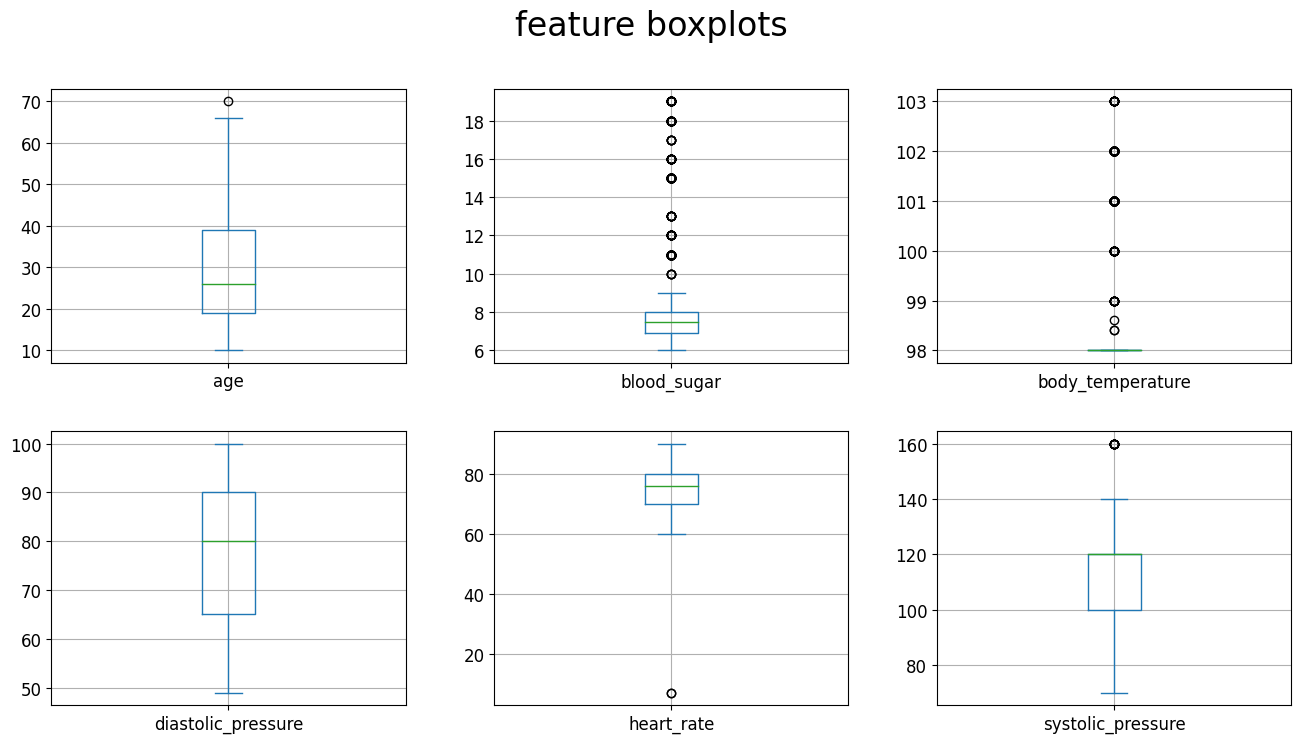

In [14]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle('feature boxplots', fontsize=24);
plt.subplots_adjust(wspace=0.25, hspace=0.25)

for i, col in enumerate(data.columns.difference(['gestational_diabetes', 'risk_level'])):
    ax = fig.add_subplot(2, 3, i + 1)

    data[col].plot(kind='box')
    ax.grid(visible=True)

In [15]:
# check
data[data.heart_rate < 60]

,age,systolic_pressure,diastolic_pressure,blood_sugar,body_temperature,heart_rate,risk_level,gestational_diabetes
499,16,120,75,7.9000,98.0000,7,low risk,likely
908,16,120,75,7.9000,98.0000,7,low risk,likely


`age`: в данных присутствует всего лишь одно аномальное значение — $70$ лет. Оставим этот признак без изменений  
`blood_sugar`: гестационный сахарный диабет (сахарный диабет беременных) диагностируется от $2\%$ до $10\%$ беременностей. Также некоторые женщины могли иметь диагноз `сахарный диабет` ещё до беременности. Эти факты объясняют наличие аномальных значений сахара в крови. Оставим этот признак без изменений  
`body_temperature`: максимальное значение температуры не превышает $40°C$ ($104°F$) и может означать наличие какой-либо болезни. Оставим этот признак без изменений  
`heart_rate`: нормальным для взрослого человека считается сердцебиение от $60$ до $100$ ударов в минуту (значения могут быть немного выше при беременности). В данных присутствуют два дубликата с аномальным значением частоты сердцебиения — $7$ ударов в минуту. Удалим эти две строки  
`diastolic_pressure`: оставим этот признак без изменений    
`systolic_pressure`: в данных есть несколько объектов с верхним артериальным давлением равным $160$ мм. рт. ст. Это завышенное значение, но не аномальное. Именно оно может указывать на наличие проблем со здоровьем и следовательно на соответствующий уровень риска беременности. Оставим этот признак без изменений

In [16]:
data = data[data.heart_rate >= 60]

## **Закодируем целевой признак:**
Будем использовать `OrdinalEncoder` для того, чтобы сохранить порядок (`low risk` < `mid risk` < `high risk`)

In [17]:
encoder = OrdinalEncoder(categories=[['low risk', 'mid risk', 'high risk']])
data.loc[:, 'risk_level'] = encoder.fit_transform(data.risk_level.to_frame())
data = data.astype({'risk_level': int})

## **Создадим базовый пайплайн для предобработки данных:**
- к количественным признакам применим скалирование `StandardScaler`
- к категориальным признакам применим кодирование `OrdinalEncoder` (порядок в признаке `gestational_diabetes` в самом деле важен)

In [18]:
preprocessor = Pipeline(steps=[('preprocessor', ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('categorical', OrdinalEncoder(), ['gestational_diabetes']),
        ('numerical', StandardScaler(), data.columns.difference(['gestational_diabetes', 'risk_level']))
        ],
))], memory='tmp/cache')
preprocessor

Pipeline(memory='tmp/cache',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(),
                                                  ['gestational_diabetes']),
                                                 ('numerical', StandardScaler(),
                                                  Index(['age', 'blood_sugar', 'body_temperature', 'diastolic_pressure',
       'heart_rate', 'systolic_pressure'],
      dtype='object'))]))])

## **Краткий вывод:**
- в данных были обработаны нарушения правил хорошего стиля в названиях признаков
- в данных были обработаны нарушения несоответствия типов у признаков
- в данные был добавлен новый признак — `gestational_diabetes`
- из данных были удалены неинформативные признаки, которые не несут ценности для прогноза
- в данных были обработаны пропущенные значения
- в данных были обработаны явные и неявные дубликаты (можно заметить, что удаление явных дубликатов изменит баланс классов в целевом признаке, а также значительно уменьшит набор данных. Поэтому мы оставили их без изменений)
- в данных были обработаны аномальные значения

# **Исследовательский анализ данных:**

## **Исследуем баланс классов:**

low risk    0.3992
mid risk    0.3320
high risk   0.2688
Name: proportion, dtype: float64

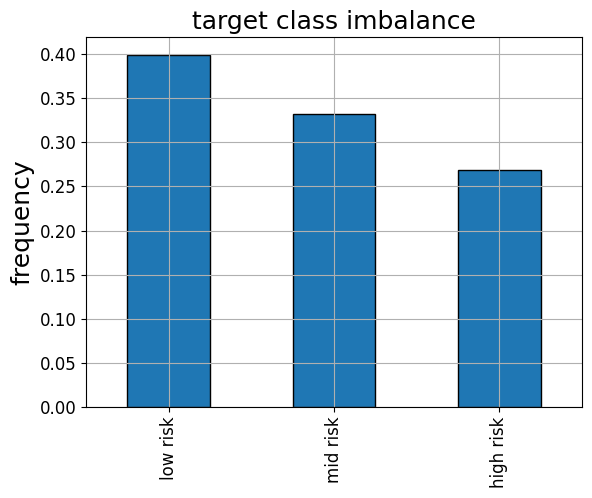

In [19]:
class_balance = pd.Series(encoder.inverse_transform(data.risk_level.to_frame()).flatten()).value_counts(normalize=True)
display(class_balance)
class_balance.plot(kind='bar', grid=True, edgecolor='black', ylabel='frequency', title='target class imbalance');

В целевом признаке присутствует небольшой дисбаланс классов

## **Проанализируем как целевой признак `risk_level` связан со всеми остальными признаками:**


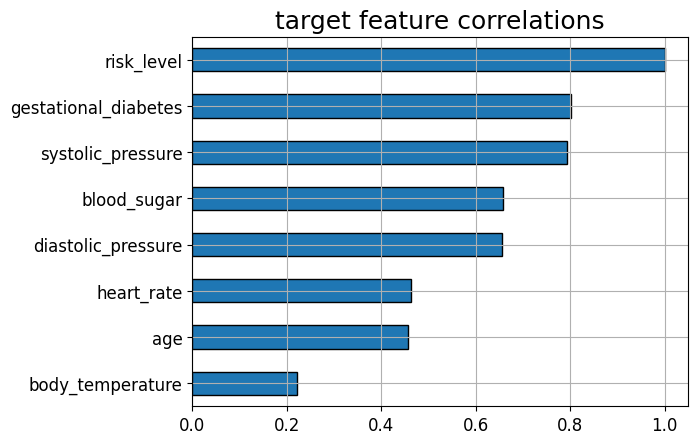

In [20]:
phik_overview = data.phik_matrix(interval_cols=['age', 'systolic_pressure', 'diastolic_pressure',
                                                'blood_sugar', 'body_temperature', 'heart_rate'])
corr_data = phik_overview['risk_level'].sort_values(key=abs)
corr_data.plot(kind='barh', edgecolor='black', title='target feature correlations', grid=True);

уровень риска сильно взаимосвязан с наличием диабета, уровенем сахара в крови и артериальным давлением

## **Краткий вывод:**
- в целевом признаке присутствует небольшой дисбаланс классов
- уровень риска сильно взаимосвязан с наличием диабета, уровенем сахара в крови и артериальным давлением

# **Обучение моделей:**
Можно заметить, что у классов в целевом признаке есть строгий порядок (`low risk` < `mid risk` < `high risk`) и ошибка прогнозирования `mid risk` вместо `high risk` не такая большая как в случае прогнозирования  `low risk` вместо `high risk`. Перед нами стоит задача порядковой классификации (`Ordinal classification`), также известная как задача порядковой регрессии (`Ordinal regression`).

Создадим датафрейм, в котором будем хранить результаты тестирования различных моделей на валидационной выборке. В интернете можно найти [статью](https://stats.stackexchange.com/questions/338904/measures-of-ordinal-classification-error-for-ordinal-regression), в которой сравниваются различные метрики для задачи порядковой классификации. Согласно этой статье `RMSE` и `MSE` подходят для данной задачи лучше остальных метрик. Будем использовать метрику `RMSE` как в качестве функции потерь, так и в качестве метрики качества для сравнения различных моделей. Дополнительно в качестве метрики качества будем использовать `Accuracy`

In [21]:
valid_results = pd.DataFrame(columns=['rmse', 'accuracy'])
best_params = {}

## **Напишем функцию для разделения данных с учетом дубликатов:**
Выделим уникальные строки из данных и разделим их по выборкам, а затем соответствующим образом добавим дубликаты, чтобы избежать утечки данных

In [22]:
def duplicated_split(dataframe, test_size=0.25):
    unique = dataframe[~dataframe.duplicated()]
    duplicates = dataframe[dataframe.duplicated()]

    # split unique rows and then add duplicates
    train_data, test_data = train_test_split(unique, test_size=test_size,
                                             random_state=RANDOM_STATE,
                                             stratify=unique.risk_level)

    train_duplicates = pd.merge(train_data, duplicates, how='inner')
    test_duplicates = pd.merge(test_data, duplicates, how='inner')

    train_data = pd.concat([train_data, train_duplicates])
    test_data = pd.concat([test_data, test_duplicates])

    return train_data, test_data

## **Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении $60\%$/$20\%$/$20\%$:**
Не забудем учесть тот факт, что в данных присутствуют дубликаты

In [23]:
train_data, valid_data = duplicated_split(data, test_size=0.2)
train_data, test_data = duplicated_split(train_data, test_size=0.25)
datasets = [train_data, valid_data, test_data]

train_features, valid_features, test_features = map(lambda x: x.drop(['risk_level'], axis=1), datasets)
train_target, valid_target, test_target = map(lambda x: x['risk_level'], datasets)

# check
display(pd.DataFrame(index=['train', 'valid', 'test'],
                     columns=['size', 'size_proportion'],
                     data=[[dataset.shape[0], dataset.shape[0] / data.shape[0]] for dataset in datasets]))

,size,size_proportion
train,600,0.5929
valid,219,0.2164
test,193,0.1907


Есть несколько подходов к решению задачи порядковой классификации . Один из них — свести задачу порядковой классификации с $k$ классами к $k-1$ задачам бинарной классификации. (см. [ссылку](https://stackoverflow.com/questions/57561189/multi-class-multi-label-ordinal-classification-with-sklearn))

Напишем класс для модели `OrdinalClassifier`, которая состоит из нескольких бинарных классификаторов (в нашем случае из двух, так как $k = 3$)

In [24]:
class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
        self.unique_class = np.NaN

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {i: self.clfs[i].predict_proba(X) for i in self.clfs}
        predicted = []
        k = len(self.unique_class) - 1
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[0][:,1])
            elif i < k:
                # Vi = Pr(y <= Vi) * Pr(y > Vi-1)
                 predicted.append((1 - clfs_predict[i][:,1]) * clfs_predict[i-1][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[k-1][:,1])
        return np.vstack(predicted).T

    def predict(self, X):
        return self.unique_class[np.argmax(self.predict_proba(X), axis=1)]

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

## **Создадим и обучим наивную модель:**

In [25]:
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', OrdinalClassifier(DummyClassifier()))])
best_model.fit(train_features, train_target)

predictions = best_model.predict(valid_features)
best_params['DummyClassifier'] = {}
valid_results.loc['DummyClassifier', 'rmse'] = root_mean_squared_error(valid_target, predictions)
valid_results.loc['DummyClassifier', 'accuracy'] = accuracy_score(valid_target, predictions)
valid_results

,rmse,accuracy
DummyClassifier,0.7645,0.4155


## **Напишем функцию кросс-валидации для optuna:**
Учтём наличие дубликатов в данных. Выделим уникальные строки из обучающей выборки, разделим эти строки на обучающую и валидационную выборки при очередном сплите, а затем соответстующим образом добавим дубликаты, чтобы избежать утечки данных. (см. [ссылку](https://stackoverflow.com/questions/63224426/how-can-i-cross-validate-by-pytorch-and-optuna))

In [26]:
def objective_cv(trial, objective, n_splits):
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    # split unique rows and then add duplicates
    train_data_unique = train_data[~train_data.duplicated()]
    train_data_duplicates = train_data[train_data.duplicated()]

    for train_idx, valid_idx in fold.split(range(len(train_data_unique))):
        train_split = train_data_unique.iloc[train_idx]
        train_split = pd.concat([train_split, pd.merge(train_split, train_data_duplicates, how='inner')])

        valid_split = train_data_unique.iloc[valid_idx]
        valid_split = pd.concat([valid_split, pd.merge(valid_split, train_data_duplicates, how='inner')])

        train_features = train_split.drop(['risk_level'], axis=1)
        valid_features = valid_split.drop(['risk_level'], axis=1)
        train_target = train_split['risk_level']
        valid_target = valid_split['risk_level']

        dataset = ((train_features, train_target), (valid_features, valid_target))
        scores.append(objective(trial, dataset))
    return np.mean(scores)

## **Создадим и обучим модель дерева решений:**
Попробуем улучшить результаты прогнозирования наивной модели при помощи модели дерева решений. При помощи перебора гиперпараметров найдём наилучшую такую модель

In [27]:
def objective(trial, dataset):
    (train_features, train_target), (valid_features, valid_target) = dataset

    classifier = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    classifier.max_depth = trial.suggest_categorical('max_depth', powers_of_two(6))
    classifier.min_samples_split = trial.suggest_categorical('min_samples_split', powers_of_two(6))
    classifier.min_samples_leaf = trial.suggest_categorical('min_samples_leaf', powers_of_two(6))

    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', OrdinalClassifier(classifier))])
    model.fit(train_features, train_target)

    return root_mean_squared_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=100)

best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', OrdinalClassifier(DecisionTreeClassifier(**study.best_trial.params)))])
best_model.fit(train_features, train_target)

predictions = best_model.predict(valid_features)
best_params['DecisionTreeClassifier'] = study.best_trial.params
valid_results.loc['DecisionTreeClassifier', 'rmse'] = root_mean_squared_error(valid_target,  predictions)
valid_results.loc['DecisionTreeClassifier', 'accuracy'] = accuracy_score(valid_target, predictions)
valid_results[['rmse', 'accuracy']]

[I 2024-07-27 18:37:20,163] A new study created in memory with name: no-name-4cacd171-6cc9-4d2d-8755-c9a02271d7bb
[I 2024-07-27 18:37:20,696] Trial 0 finished with value: 0.7665005753319818 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7665005753319818.
[I 2024-07-27 18:37:21,052] Trial 1 finished with value: 0.7887011124195038 and parameters: {'max_depth': 64, 'min_samples_split': 8, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.7665005753319818.
[I 2024-07-27 18:37:21,558] Trial 2 finished with value: 0.7902242621497229 and parameters: {'max_depth': 8, 'min_samples_split': 32, 'min_samples_leaf': 64}. Best is trial 0 with value: 0.7665005753319818.
[I 2024-07-27 18:37:21,890] Trial 3 finished with value: 0.7860391801581308 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7665005753319818.
[I 2024-07-27 18:37:22,257] Trial 4 finished with value: 0.76

,rmse,accuracy
DummyClassifier,0.7645,0.4155
DecisionTreeClassifier,0.6990,0.6073


## **Создадим и обучим модель случайного леса:**
Попробуем улучшить результаты прогнозирования дерева решений при помощи модели случайного леса. При помощи перебора гиперпараметров найдём наилучшую такую модель

In [28]:
def objective(trial, dataset):
    (train_features, train_target), (valid_features, valid_target) = dataset

    classifier = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    classifier.criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    classifier.max_depth = trial.suggest_categorical('max_depth', powers_of_two(6))
    classifier.n_estimators = trial.suggest_categorical('n_estimators', powers_of_two(6))
    classifier.min_samples_split = trial.suggest_categorical('min_samples_split', powers_of_two(6))

    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', OrdinalClassifier(classifier))])
    model.fit(train_features, train_target)

    return root_mean_squared_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=200)

best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', OrdinalClassifier(RandomForestClassifier(**study.best_trial.params)))])
best_model.fit(train_features, train_target)

predictions = best_model.predict(valid_features)
best_params['RandomForestClassifier'] = study.best_trial.params
valid_results.loc['RandomForestClassifier', 'rmse'] = root_mean_squared_error(valid_target,  predictions)
valid_results.loc['RandomForestClassifier', 'accuracy'] = accuracy_score(valid_target, predictions)
valid_results[['rmse', 'accuracy']]

[I 2024-07-27 18:37:52,363] A new study created in memory with name: no-name-e7eb3bb1-0273-40c0-a0c3-1bccadad6dbd
[I 2024-07-27 18:37:53,566] Trial 0 finished with value: 0.7066264919428448 and parameters: {'criterion': 'gini', 'max_depth': 16, 'n_estimators': 64, 'min_samples_split': 8}. Best is trial 0 with value: 0.7066264919428448.
[I 2024-07-27 18:37:54,236] Trial 1 finished with value: 0.6974801338589774 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'n_estimators': 32, 'min_samples_split': 8}. Best is trial 1 with value: 0.6974801338589774.
[I 2024-07-27 18:37:54,517] Trial 2 finished with value: 0.7196384520914139 and parameters: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 8, 'min_samples_split': 64}. Best is trial 1 with value: 0.6974801338589774.
[I 2024-07-27 18:37:54,701] Trial 3 finished with value: 0.7573121161013942 and parameters: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 2, 'min_samples_split': 2}. Best is trial 1 with value: 0.69748013

,rmse,accuracy
DummyClassifier,0.7645,0.4155
DecisionTreeClassifier,0.6990,0.6073
RandomForestClassifier,0.6552,0.6119


## **Создадим и обучим модель градиентного бустинга:**
Попробуем улучшить результаты прогнозирования случайного леса при помощи модели градиентного бустинга. При помощи перебора гиперпараметров найдём наилучшую такую модель

In [29]:
def objective(trial, dataset):
    (train_features, train_target), (valid_features, valid_target) = dataset

    classifier = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbosity=-1)
    classifier.max_depth = trial.suggest_categorical('max_depth', powers_of_two(6))
    classifier.n_estimators = trial.suggest_categorical('n_estimators', powers_of_two(6))
    classifier.num_leaves = trial.suggest_categorical('num_leaves', powers_of_two(6))
    classifier.learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])

    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', OrdinalClassifier(classifier))])
    model.fit(train_features, train_target)

    return root_mean_squared_error(valid_target, model.predict(valid_features))

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(partial(objective_cv, objective=objective, n_splits=5), n_trials=200)

best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', OrdinalClassifier(LGBMClassifier(**study.best_trial.params)))])
best_model.fit(train_features, train_target)

predictions = best_model.predict(valid_features)
best_params['LGBMClassifier'] = study.best_trial.params
valid_results.loc['LGBMClassifier', 'rmse'] = root_mean_squared_error(valid_target,  predictions)
valid_results.loc['LGBMClassifier', 'accuracy'] = accuracy_score(valid_target, predictions)
valid_results[['rmse', 'accuracy']]

[I 2024-07-27 18:39:18,417] A new study created in memory with name: no-name-7046f16c-b5eb-4c57-bbd7-743f546ad533
[I 2024-07-27 18:39:18,719] Trial 0 finished with value: 0.7859525539670331 and parameters: {'max_depth': 2, 'n_estimators': 2, 'num_leaves': 8, 'learning_rate': 0.1}. Best is trial 0 with value: 0.7859525539670331.
[I 2024-07-27 18:39:19,062] Trial 1 finished with value: 0.6689544820301851 and parameters: {'max_depth': 8, 'n_estimators': 32, 'num_leaves': 4, 'learning_rate': 0.1}. Best is trial 1 with value: 0.6689544820301851.
[I 2024-07-27 18:39:19,427] Trial 2 finished with value: 0.7615193277581142 and parameters: {'max_depth': 32, 'n_estimators': 64, 'num_leaves': 8, 'learning_rate': 0.001}. Best is trial 1 with value: 0.6689544820301851.
[I 2024-07-27 18:39:19,622] Trial 3 finished with value: 0.7715249636553005 and parameters: {'max_depth': 32, 'n_estimators': 4, 'num_leaves': 16, 'learning_rate': 0.1}. Best is trial 1 with value: 0.6689544820301851.
[I 2024-07-27 1

[LightGBM] [Info] Number of positive: 364, number of negative: 236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.606667 -> initscore=0.433322
[LightGBM] [Info] Start training from score 0.433322
[LightGBM] [Info] Number of positive: 175, number of negative: 425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291667 -> initscore=-0.887303
[LightGBM] [Info] Start training from score -0.887303


,rmse,accuracy
DummyClassifier,0.7645,0.4155
DecisionTreeClassifier,0.6990,0.6073
RandomForestClassifier,0.6552,0.6119
LGBMClassifier,0.7055,0.5708


## **Проанализируем результаты моделирования и выберем наилучшую модель:**

In [30]:
valid_results[['rmse', 'accuracy']]

,rmse,accuracy
DummyClassifier,0.7645,0.4155
DecisionTreeClassifier,0.6990,0.6073
RandomForestClassifier,0.6552,0.6119
LGBMClassifier,0.7055,0.5708


В качестве наилучшей по результатам учёта двух метрик будем считать модель `OrdinalClassifier`, состоящую из двух `RandomForestClassifier`



## **Краткий вывод:**
- мы сформулировали задача порядковой классификации (`Ordinal classification`) и обучили несколько моделей `OrdinalClassifier` (состоящих из классификаторов `DecisionTreeClassifier`, `RandomForestClassifier`, `LGBMClassifier`) с перебором гиперпараметров
- после тестирования на валидационной выборке все модели показали результаты по двум метрикам (`rmse` и `accuracy`) лучше наивной модели, но наилучшей оказалась модель `OrdinalClassifier`, состоящая из классификаторов `RandomForestClassifier`

# **Тестирование и анализ наилучшей модели:**

Создадим датафрейм, в котором будем хранить результаты тестирования наилучшей модели на тренировочной, валидационной и тестовой выборках.

In [31]:
results = pd.DataFrame(columns=['rmse', 'accuracy'], index=['train', 'valid', 'test'])

## **Протестируем наилучшую модель на тренировочной, валидационной и тестовой выборках:**
Перед тестированием на тестовой выборке обучим модель на объединении тренировочной и валидационной выборкок

In [35]:
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', OrdinalClassifier(RandomForestClassifier(**best_params['RandomForestClassifier'])))])
best_model.fit(train_features, train_target)
results.loc['train', 'rmse'] = root_mean_squared_error(train_target, best_model.predict(train_features))
results.loc['train', 'accuracy'] = accuracy_score(train_target, best_model.predict(train_features))
results.loc['valid', 'rmse'] = root_mean_squared_error(valid_target, best_model.predict(valid_features))
results.loc['valid', 'accuracy'] = accuracy_score(valid_target, best_model.predict(valid_features))

best_model.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]))
results.loc['test', 'rmse'] = root_mean_squared_error(test_target, best_model.predict(test_features))
results.loc['test', 'accuracy'] = accuracy_score(test_target, best_model.predict(test_features))
results

,rmse,accuracy
train,0.6646,0.6933
valid,0.7340,0.5434
test,0.4553,0.7927


## **Проведём графический анализ:**


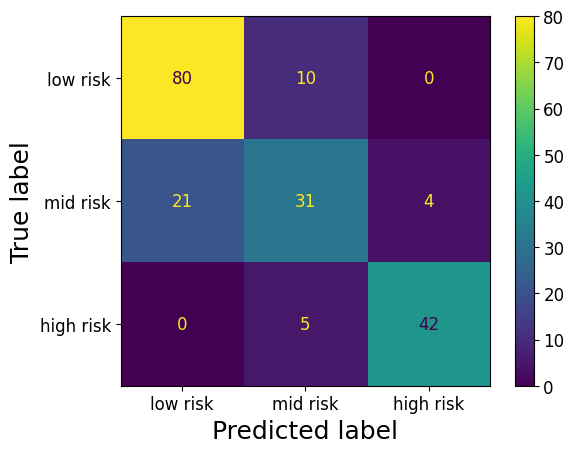

In [36]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_target, best_model.predict(test_features)),
                       display_labels=['low risk', 'mid risk', 'high risk']).plot();

## **Краткий вывод:**
- по результатам тестирования можно заметить, что все ошибки наилучшей модели по своим значениям не велики. Она никогда не путает уровень риска `low risk` с `high risk` и наоборот

# **Общий вывод:**
- после исследования и предобработки данных мы свели задачу прогнозирования уровня риска беременных к задаче порядковой классификации (`Ordinal сlassification`)
- мы обучили несколько моделей `OrdinalClassifier` (состоящих из классификаторов `DecisionTreeClassifier`, `RandomForestClassifier`, `LGBMClassifier`) с перебором гиперпараметров. Все они показали результаты прогнозирования лучше наивной модели  
- в результате тестирования моделей на валидационной выборке лучше всех оказалась модель `OrdinalClassifier` состоящая из классификаторов `RandomForestClassifier`
- по результатам тестирования можно заметить, что все ошибки наилучшей модели по своим значениям не велики. Она никогда не путает уровень риска `low risk` с `high risk` и наоборот
